In [ ]:
!pip install transformers
!pip install evaluate

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm.notebook import tqdm
sns.set(font_scale=1.4)

import torch
from torch.utils.data import DataLoader

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

In [26]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

# Загружаем данные

In [ ]:
!wget 'https://raw.githubusercontent.com/suppukerr/project_auto/main/train_aspects.txt'

!wget 'https://raw.githubusercontent.com/suppukerr/project_auto/main/train_cats.txt'

!wget 'https://raw.githubusercontent.com/suppukerr/project_auto/main/train_reviews.txt'

In [5]:
train_aspects = pd.read_csv('train_aspects.txt', sep='\t', names=['text_id', 'category', 'mention', 'start', 'end', 'sentiment'])
train_texts = pd.read_csv('train_reviews.txt', delimiter='\t', names=['text_id','text'])
train_cats = pd.read_csv('train_cats.txt', delimiter='\t')
data_train = train_aspects.merge(train_texts, on='text_id') #объединяем датасеты с отзывами и аспектами

In [10]:
sentiment_dict = {sent: n for n, sent in enumerate(data_train['sentiment'].unique())}

In [11]:
sentiment_dict

{'neutral': 0, 'positive': 1, 'both': 2, 'negative': 3}

In [12]:
data_train['sentiment'] = data_train['sentiment'].map(sentiment_dict) #мапим тональности в индексы

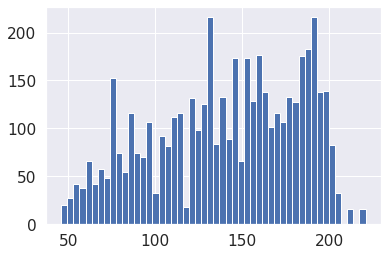

In [13]:
#распределение количества токенов в отзывах
seq_len = [len(str(i).split()) for i in data_train['text']]
pd.Series(seq_len).hist(bins = 50)

In [14]:
max([len(str(i).split()) for i in data_train['text']]) #максимальное количество токенов

221

### Подготовка данных к модели

In [15]:
train_data, val_data = train_test_split(data_train, test_size=0.25)

In [16]:
def masked_text(df):
  df['text'] = df.apply (lambda x: x['text'][:x['start']] + '[MASK]' + x['text'][x['end']:], axis= 1 )
  df = df[['text', 'sentiment']]
  df = df.rename(columns = {'sentiment':'label'})
  return df

In [17]:
train_data_ = masked_text(train_data)
val_data_ = masked_text(val_data)

train_text = train_data_['text'].astype('str')
train_labels = train_data_['label']

val_text = val_data_['text'].astype('str')
val_labels = val_data_['label']

In [19]:
def seed_all(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False
seed_all(42)

In [31]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# Fine-tune cointegrated/rubert-tiny

In [36]:
model_name = 'cointegrated/rubert-tiny'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)

In [38]:
tokens_train = tokenizer.batch_encode_plus(
    list(train_text.values),
    max_length = 221,
    padding = 'max_length',
    truncation = True, 
    return_tensors='pt'
)

tokens_val = tokenizer.batch_encode_plus(
    list(val_text.values),
    max_length = 221,
    padding = 'max_length',
    truncation = True, 
    return_tensors='pt'
)

In [39]:
class Data(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels)
        
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
train_dataset = Data(tokens_train, torch.tensor([[x] for x in train_labels]))
val_dataset = Data(tokens_val, torch.tensor([[x] for x in val_labels]))

<ipython-input-39-68bf3a76a5c2>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(labels)


In [40]:
print('Доступна ли видеокарта:', torch.cuda.is_available())
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('using device:', device)

Доступна ли видеокарта: True
using device: cuda


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)
model_bert = model.cuda()

In [32]:
training_args = TrainingArguments(
    output_dir = './results', #Выходной каталог
    num_train_epochs = 5, #Кол-во эпох для обучения
    per_device_train_batch_size = 8, #Размер пакета для каждого устройства во время обучения
    per_device_eval_batch_size = 8, #Размер пакета для каждого устройства во время валидации
    weight_decay =0.01, #Понижение весов
    logging_dir = './logs', #Каталог для хранения журналов
    load_best_model_at_end = True, #Загружать ли лучшую модель после обучения
    learning_rate = 1e-5, #Скорость обучения
    evaluation_strategy ='epoch', #Валидация после каждой эпохи (можно сделать после конкретного кол-ва шагов)
    logging_strategy = 'epoch', #Логирование после каждой эпохи
    save_strategy = 'epoch', #Сохранение после каждой эпохи
    save_total_limit = 1,
    seed=21)

In [42]:
trainer = Trainer(
    model=model_bert,
    args=training_args,
    tokenizer = tokenizer,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [43]:
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3572
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2235
  Number of trainable parameters = 11785420
<ipython-input-39-68bf3a76a5c2>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
<ipython-input-39-68bf3a76a5c2>:8: UserWarning: To copy construct from a tensor, it is recommended

Epoch,Training Loss,Validation Loss,Accuracy
1,1.010700,0.885801,0.670025
2,0.905400,0.822099,0.673384
3,0.862700,0.797530,0.681780
4,0.844000,0.788241,0.685139
5,0.838100,0.786259,0.692695


***** Running Evaluation *****
  Num examples = 1191
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-447
Configuration saved in ./results/checkpoint-447/config.json
Model weights saved in ./results/checkpoint-447/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-447/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-447/special_tokens_map.json
<ipython-input-39-68bf3a76a5c2>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
<ipython-input-39-68bf3a76a5c2>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
***** Running 

TrainOutput(global_step=2235, training_loss=0.8921814101387724, metrics={'train_runtime': 83.5244, 'train_samples_per_second': 213.83, 'train_steps_per_second': 26.759, 'total_flos': 56863335678240.0, 'train_loss': 0.8921814101387724, 'epoch': 5.0})

### Быстро, но качество не сильно радует, так как модель маловата

# Fine-tune sberbank-ai/ruBert-base

In [20]:
model_name = 'sberbank-ai/ruBert-base'

In [21]:
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)

Downloading:   0%|          | 0.00/590 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

In [22]:
tokens_train = tokenizer.batch_encode_plus(
    list(train_text.values),
    max_length = 221,
    padding = 'max_length',
    truncation = True, 
    return_tensors='pt'
)

tokens_val = tokenizer.batch_encode_plus(
    list(val_text.values),
    max_length = 221,
    padding = 'max_length',
    truncation = True, 
    return_tensors='pt'
)

In [23]:
class Data(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels)
        
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
train_dataset = Data(tokens_train, torch.tensor([[x] for x in train_labels]))
val_dataset = Data(tokens_val, torch.tensor([[x] for x in val_labels]))

<ipython-input-23-68bf3a76a5c2>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(labels)


## Скачиваем и настраиваем модель

In [29]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)
model_bert = model.cuda()

Downloading:   0%|          | 0.00/716M [00:01<?, ?B/s]

Some weights of the model checkpoint at sberbank-ai/ruBert-base were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not in

In [33]:
trainer = Trainer(
    model=model_bert,
    args=training_args,
    tokenizer = tokenizer,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [34]:
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3572
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2235
  Number of trainable parameters = 178310404
<ipython-input-23-68bf3a76a5c2>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
<ipython-input-23-68bf3a76a5c2>:8: UserWarning: To copy construct from a tensor, it is recommende

Epoch,Training Loss,Validation Loss,Accuracy
1,0.885600,0.749251,0.708648
2,0.692500,0.491133,0.816961
3,0.462500,0.459098,0.831234
4,0.338600,0.527014,0.842149
5,0.270500,0.537683,0.835432


***** Running Evaluation *****
  Num examples = 1191
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-447
Configuration saved in ./results/checkpoint-447/config.json
Model weights saved in ./results/checkpoint-447/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-447/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-447/special_tokens_map.json
<ipython-input-23-68bf3a76a5c2>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
<ipython-input-23-68bf3a76a5c2>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
***** Running 

TrainOutput(global_step=2235, training_loss=0.5299565564866034, metrics={'train_runtime': 988.7454, 'train_samples_per_second': 18.063, 'train_steps_per_second': 2.26, 'total_flos': 2028386271456480.0, 'train_loss': 0.5299565564866034, 'epoch': 5.0})

#### На большой модели качество получилось гораздо лучше